In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
np.random.seed(42)

In [38]:
def get_weights_ffd(d, thresh):
    '''
    computes weights for differentiating for fixed window
    ''' 
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thresh:
            break 
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w
            

In [39]:
def frac_diff_ffd(series, d, thresh=1e-5):
    ''' 
    fractional differentiation with constant width window 
    ''' 
    w = get_weights_ffd(d, thresh)  
    width = len(w) - 1
    df = {}

    for name in series.columns:
        series_f = series[[name]].ffill().dropna()
        df_ = pd.Series(index=np.arange(series.shape[0]), dtype=object)
        for iloc1 in range(width, series_f.shape[0]):
            loc0, loc1 = series_f.index[iloc1 - width], series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.dropna().copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [40]:
def ffd(process, thresh=0.01):
    ''' 
    find the optimal fractional differencing factor 
    '''
    for d in np.linspace(0, 1, 11):
        process_diff = frac_diff_ffd(pd.DataFrame(process), d, thresh)
        adf = adfuller(process_diff[process.name], maxlag=1, regression='c', autolag=None)
        if adf[1] < 0.05:
            break
    return process_diff[process.name]

In [44]:
n = 1000
time = np.arange(n)
time_series = np.random.randn(n).cumsum()

In [45]:
diff_series = ffd(pd.Series(time_series, name='ts'))
result_diff = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
print('ADF Statistic (differenced): ', result_diff[0])
print('p-value (differenced): ', result_diff[1])
for key, value in result_diff[4].items():
    print('Critical values (differenced): ', key, value)

ADF Statistic (differenced):  -3.3136654785988733
p-value (differenced):  0.01427856888725201
Critical values (differenced):  1% -3.4369860032923145
Critical values (differenced):  5% -2.8644697838498376
Critical values (differenced):  10% -2.5683299626694422


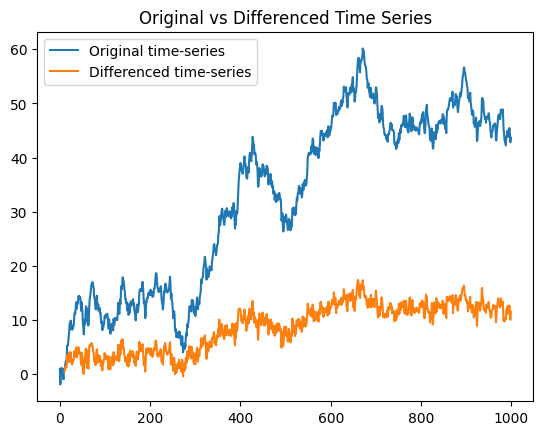

In [47]:
plt.plot(time_series, label="Original time-series")
plt.plot(diff_series, label="Differenced time-series")
plt.title('Original vs Differenced Time Series')
plt.legend()